In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
detail_county_raw_df = pd.read_csv("../maine-data/demographics/Maine State and County 5-Year Age and Sex Cohort Projections.csv", encoding="utf-16", delimiter='\t', skiprows=1, thousands=",")
detail_county_raw_df

,Region,Unnamed: 1,Age Cohort,"2020, Observed population","2025, Projected population","2030, Projected Population","2035, Projected Population","2040, Projected Population"
0,Maine,Female Population,0-4,31013,29830,29651,29026,28488
1,Maine,Female Population,5-9,33096,31480,30605,30480,29959
2,Maine,Female Population,10-14,36660,34632,32052,31300,31208
3,Maine,Female Population,15-19,38252,36802,35697,32859,32278
4,Maine,Female Population,20-24,36363,37080,35892,34807,33031
...,...,...,...,...,...,...,...,...
641,York County,Male Population,70-74,5871,6850,7671,7515,7073
642,York County,Male Population,75-79,3547,4862,6193,6893,6740
643,York County,Male Population,80-84,2057,2725,4158,5238,5789
644,York County,Male Population,85+,1705,2038,2909,4219,5344


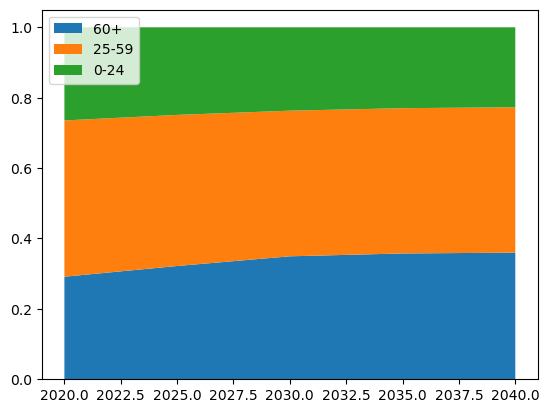

In [3]:
years = [2020, 2025, 2030, 2035, 2040]
years_str = ["2020", "2025", "2030", "2035", "2040"]

detail_county_df = detail_county_raw_df.rename({"Unnamed: 1": "demographic"}, axis=1)
col_rename = lambda name: name.split(",")[0] if name.startswith("20") else name
detail_county_df = detail_county_df.rename(col_rename, axis=1)
# detail_county_df = pd.melt(detail_county_df, id_vars=["Region", "demographic", "Age Cohort"], value_vars=years_str, var_name="year", value_name="projected")
detail_county_df_male = detail_county_df[detail_county_df["demographic"] == "Male Population"].reset_index()
detail_county_df_female = detail_county_df[detail_county_df["demographic"] == "Female Population"].reset_index()

assert detail_county_df_male.shape == detail_county_df_female.shape

detail_county_df = detail_county_df_male[["Region", "Age Cohort"]]
detail_county_df.loc[:, years_str] = detail_county_df_male[years_str] + detail_county_df_female[years_str]
detail_county_df.loc[:, 'Age Cohort'] = detail_county_df['Age Cohort'].str.split(r'[-+]').str[0]

def age_mapper(age):
    if age == "Total":
        return age
    age = int(age)
    if age <= 24:
        return "0-24"
    elif age <= 59:
        return "25-59"
    else:
        return "60+"
detail_county_df.loc[:, 'Age Cohort'] = detail_county_df['Age Cohort'].map(age_mapper)
detail_county_df = detail_county_df[detail_county_df['Age Cohort'] != "Total"]

detail_county_df = detail_county_df.groupby(['Region', 'Age Cohort'])[years_str].sum()

detail_county_df = detail_county_df / detail_county_df.groupby(['Region',])[years_str].transform('sum')
detail_county_df
maine_pop_df = detail_county_df.loc["Maine", :]
x = years
y = maine_pop_df.loc[:, years_str].to_numpy().tolist()[::-1]
labels = maine_pop_df.index.tolist()[::-1]
plt.stackplot(x,y, labels=labels)
plt.legend(loc='upper left')
plt.show()

/tmp/ipykernel_3820/419955417.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['{:,.0%}'.format(x) for x in ax.get_yticks()])


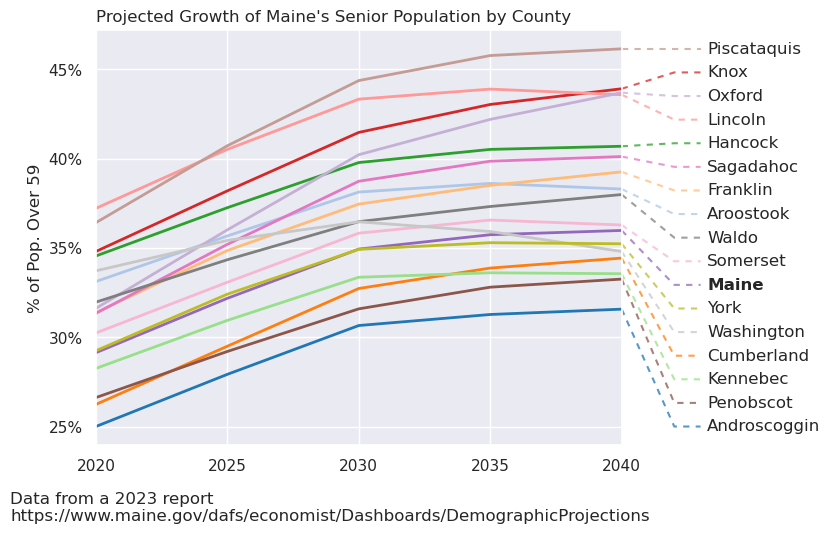

In [7]:
palette = 'tab20'
county_aging_pop = detail_county_df.loc[(slice(None), '60+'), :]
county_aging_pop = county_aging_pop.reset_index().set_index("Region").drop("Age Cohort", axis=1)

county_aging_pop = county_aging_pop.reset_index().melt(id_vars="Region", value_vars=years_str, var_name="year")
county_aging_pop['year'] = county_aging_pop['year'].astype(int)
county_aging_pop = county_aging_pop.rename({"Region": "County"}, axis=1)
county_aging_pop['County'] = county_aging_pop['County'].str.split(' ').str[0]


sns.set_style("darkgrid")
sns.set_context("notebook")
fig, ax = plt.subplots(figsize=(8.5, 5))

ax = sns.lineplot(ax=ax, data=county_aging_pop, x="year", y="value", hue="County", palette=palette, legend=False, linewidth=2)
ax.set_yticklabels(['{:,.0%}'.format(x) for x in ax.get_yticks()])
ax.set_xticks(years)
ax.set_xlabel("")
ax.set_xlim(2020, 2040)

counties = sorted(list(set(county_aging_pop['County'].tolist())))

#may need to refine
max_val = county_aging_pop['value'].max()
min_val = county_aging_pop['value'].min()

final_values = county_aging_pop[county_aging_pop['year'] == 2040].copy()
final_values['value_rank'] = final_values['value'].rank(ascending=False)

final_values['label_pos'] = np.interp(final_values['value_rank'].tolist(), [1, 17], [max_val, min_val])
final_values['cmap_val'] = (final_values['County'].rank(ascending=True) - 1) / 19

x_start, x_mid, x_end = 2040, 2042, 2043

for county, val, label_pos_y, cmap_val in final_values[['County', 'value', 'label_pos', 'cmap_val']].itertuples(index=False, name=None):
    color = plt.get_cmap(palette)(cmap_val)
    ax.plot([x_start, x_mid, x_end], 
        [val, label_pos_y, label_pos_y], 
        alpha=0.75, ls=(0, (3, 3)), 
        color=color,
        clip_on=False
    )
    
    ax.text(
        x_end + 0.25, 
        label_pos_y, 
        county, 
        va="center",
        weight="bold" if county == "Maine" else None,
    )
ax.set_ylabel(r"% of Pop. Over 59")
# ax.set_title("Projected Growth of Maine's Aging Population by County", loc='left')
ax.set_title("Projected Growth of Maine's Senior Population by County", loc='left')

fig.text(0, 0., 'Data from a 2023 report\nhttps://www.maine.gov/dafs/economist/Dashboards/DemographicProjections', horizontalalignment='left', verticalalignment="top")

fig.tight_layout()

fig.savefig('out/AgingCounties.png', bbox_inches='tight', dpi=200)